# Scattering from a sphere using a combined direct formulation
## Background

In this tutorial, we will solve the problem of scattering from the unit sphere $\Omega$ using a combined integral formulation and an incident wave defined by

$$
u^{\text{inc}}(\mathbf x) = \mathrm{e}^{\mathrm{i} k x}.
$$

where $\mathbf x = (x, y, z)$.

The PDE is given by the Helmholtz equation:

$$
\Delta u + k^2 u = 0, \quad \text{ in } \mathbb{R}^3 \backslash \Omega,
$$

where $u=u^\text{s}+u^\text{inc}$ is the total acoustic field and $u^\text{s}$ satisfies the Sommerfeld radiation condition

$$
\frac{\partial u^\text{s}}{\partial r}-\mathrm{i}ku^\text{s}=o(r^{-1})
$$

for $r:=|\mathbf{x}|\rightarrow\infty$.

From Green's representation formula, one can derive that

$$
u(\mathbf x) = u^\text{inc}-\int_{\Gamma}g(\mathbf x,\mathbf y)\frac{\partial u}{\partial\nu}(\mathbf y)\mathrm{d}\mathbf{y}.
$$

Here, $g(\mathbf x, \mathbf y)$ is the acoustic Green's function given by

$$
g(\mathbf x, \mathbf y):=\frac{\mathrm{e}^{\mathrm{i} k |\mathbf{x}-\mathbf{y}|}}{4 \pi |\mathbf{x}-\mathbf{y}|}.
$$

The problem has therefore been reduced to computing the normal derivative $u_\nu:=\frac{\partial u}{\partial\nu}$ on the boundary $\Gamma$. This is achieved using the following boundary integral equation formulation.

$$
(\tfrac12\mathsf{Id} + \mathsf{K}' - \mathrm{i} \eta \mathsf{V}) u_\nu(\mathbf{x}) = \frac{\partial u^{\text{inc}}}{\partial \nu}(\mathbf{x}) - \mathrm{i} \eta u^{\text{inc}}(\mathbf{x}), \quad \mathbf{x} \in \Gamma.
$$

where $\mathsf{Id}$, $\mathsf{K}'$ and $\mathsf{V}$ are identity, adjoint double layer and single layer <a href='https://bempp_cl.com/2017/07/11/available_operators/'>boundary operators</a>. More details of the derivation of this formulation and its properties can be found in the article <a href='http://journals.cambridge.org/action/displayAbstract?fromPage=online&aid=8539370&fileId=S0962492912000037' target='new'>Chandler-Wilde <em>et al</em> (2012)</a>.

## Implementation

First we import the Bempp module and NumPy.

In [1]:
import bempp_cl.api
import numpy as np

We define the wavenumber

In [2]:
k = 15.0

The following command creates a sphere mesh.

In [3]:
grid = bempp_cl.api.shapes.regular_sphere(3)

As basis functions, we use piecewise constant functions over the elements of the mesh. The corresponding space is initialised as follows.

In [4]:
piecewise_const_space = bempp_cl.api.function_space(grid, "DP", 0)

We now initialise the <a href='https://bempp_cl.com/2017/07/11/operators/'>boundary operators</a>.
A boundary operator always takes at least three space arguments: a domain space, a range space and the test space (dual to the range). In this example we only work on the space $\mathcal{L}^2(\Gamma)$ and we can choose all spaces to be identical.

In [5]:
identity = bempp_cl.api.operators.boundary.sparse.identity(
    piecewise_const_space, piecewise_const_space, piecewise_const_space
)
adlp = bempp_cl.api.operators.boundary.helmholtz.adjoint_double_layer(
    piecewise_const_space, piecewise_const_space, piecewise_const_space, k
)
slp = bempp_cl.api.operators.boundary.helmholtz.single_layer(
    piecewise_const_space, piecewise_const_space, piecewise_const_space, k
)

Standard arithmetic operators can be used to create linear combinations of boundary operators.

In [6]:
lhs = 0.5 * identity + adlp - 1j * k * slp

We now form the right-hand side by defining a <a href='https://bempp_cl.com/2017/07/11/grid-functions/'>GridFunction</a> using Python callable.

In [7]:
@bempp_cl.api.complex_callable
def combined_data(x, n, domain_index, result):
    result[0] = 1j * k * np.exp(1j * k * x[0]) * (n[0] - 1)


grid_fun = bempp_cl.api.GridFunction(piecewise_const_space, fun=combined_data)

We can now use GMRES to solve the problem.

In [8]:
from bempp_cl.api.linalg import gmres

In [9]:
neumann_fun, info = gmres(lhs, grid_fun, tol=1e-5)

`gmres` returns a grid function `neumann_fun` and an integer `info`. When everything works fine info is equal to 0.

At this stage, we have the surface solution of the integral equation. Now we will evaluate the solution in the domain of interest. We define the evaluation points as follows.

In [10]:
Nx = 200
Ny = 200
xmin, xmax, ymin, ymax = [-3, 3, -3, 3]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]
points = np.vstack((plot_grid[0].ravel(), plot_grid[1].ravel(), np.zeros(plot_grid[0].size)))
u_evaluated = np.zeros(points.shape[1], dtype=np.complex128)
u_evaluated[:] = np.nan

This will generate a grid of points in the $x$-$y$ plane.

Then we create a single layer potential operator and use it to evaluate the solution at the evaluation points. The variable ``idx`` allows to compute the solution only at points located outside the unit circle of the plane. We use a single layer potential operator to evaluate the solution at the observation points.

In [11]:
x, y, z = points
idx = np.sqrt(x**2 + y**2) > 1.0

from bempp_cl.api.operators.potential import helmholtz as helmholtz_potential

slp_pot = helmholtz_potential.single_layer(piecewise_const_space, points[:, idx], k)
res = np.real(np.exp(1j * k * points[0, idx]) - slp_pot.evaluate(neumann_fun))
u_evaluated[idx] = res.flat

We now plot the slice of the domain solution.

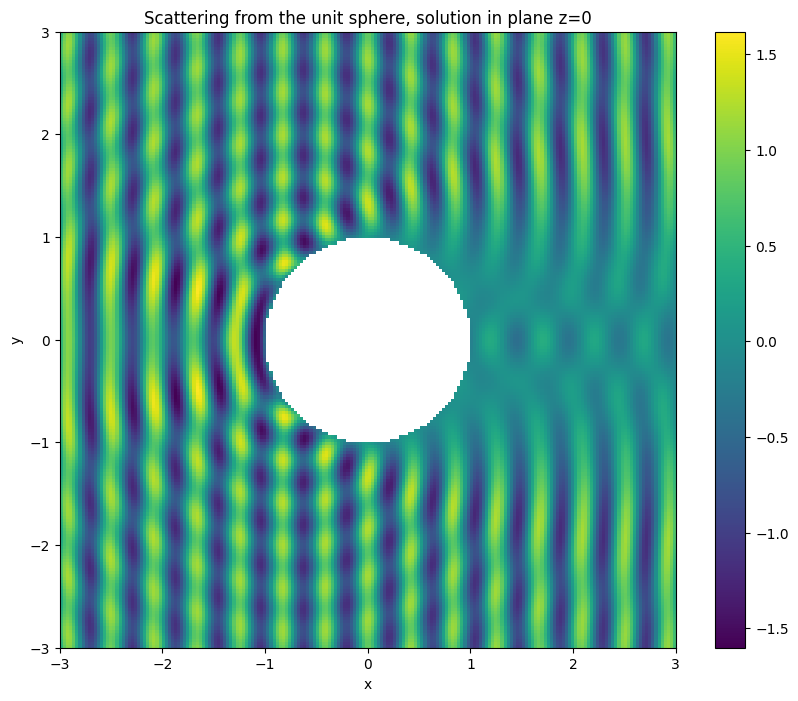

In [12]:
try:
    get_ipython().run_line_magic("matplotlib", "inline")
    ipython = True
except NameError:
    ipython = False

u_evaluated = u_evaluated.reshape((Nx, Ny))

from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(u_evaluated.T), extent=[-3, 3, -3, 3])
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.title("Scattering from the unit sphere, solution in plane z=0")
if not ipython:
    plt.savefig("example-helmholtz_combined_exterior.png")